# Classwork 10 - Ταξινόμηση με χρήση λογιστικής παλινδρόμησης, δέντρων αποφάσεων και τυχαίου δάσους. 

Μέχρι τώρα έχουμε δει αρκετούς αλγορίθμους που τους χρησιμοποιήσαμε μόνο για παλινδρόμηση. 
Παράλληλα με τα προβλήματα παλινδρόμησης όμως μπορούμε να λύσουμε και ερωτήσεις όπως π.χ. σε ποια ομάδα, τάξη (class) ανήκει ένα κρασί, ένα σπίτι ή αν ένας όγκος είναι κακοήθης. 

Εκεί θα επικεντρωθούμε σήμερα, στην πρόβλεψη της κακοήθειας των όγκων.  


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn import datasets

## Προετοιμασία των δεδομένων

In [32]:
# Εισαγωγή δεδομένων
cancer_set = datasets.load_breast_cancer()
# Μετατροπή
cancer_df = pd.DataFrame(cancer_set.data, columns=cancer_set.feature_names)
# Προσθέτουμε το target 
cancer_df['diagnosis'] = pd.Series(cancer_set.target)

In [33]:
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


Συνολικά έχουμε 569 δείγματα. Τα 212 είναι κακοήθη και τα 357 καλοήθη.  

In [34]:
cancer_df.diagnosis.value_counts()

1    357
0    212
Name: diagnosis, dtype: int64

## Καθάρισμα

In [35]:
# Έλεγχος κενών τιμών
print("Σύνολο δεδομένων: "+str(cancer_df.shape))
print("Κενές τιμές: \n"+str(cancer_df.isnull().sum()))

Σύνολο δεδομένων: (569, 31)
Κενές τιμές: 
mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
diagnosis                  0
dtype: int64


In [36]:
# Παρόλο που δεν έχουμε βρει κενές τιμές, η μεθοδολογία ελέγχου είναι αυτή:
# α. λίστα με κενές τιμές
missing_values = ["n/a", "na", "--", 999,9999]   
# β. Replace 
cancer_df.replace(to_replace = missing_values, value = np.nan, inplace = True) 
# γ. Drop NaNs 
cancer_df.dropna(inplace=True) 
# δ. Reindex για να μην μείνουν κενά στο index 
cancer_df.reset_index(drop=True, inplace=True)  
# Έλεγχος τιμών
print("Σύνολο δεδομένων: "+str(cancer_df.shape))

Σύνολο δεδομένων: (569, 31)


In [37]:
# Έλεγχος πόσα δείγματα είναι κακοήθη.
np.sum(cancer_df.diagnosis)

357

## Εξισορρόπηση


Μια πτυχή που πρέπει να ληφθεί υπόψη στην ταξινόμηση είναι ο αριθμός των δειγμάτων ανά τάξη. Στα δεδομένα μας έχουμε περίπου 63% καλοήθεις περιπτώσεις. Όταν προβλέπουμε πάντα "καλοήθη", θα πετυχαίναμε μεν μεγαλύτερη ακρίβεια από το 50%, αλλά το μοντέλο μας δεν θα πρόβλεπε σωστά. 

Μια πιθανή λύση είναι να ισορροπήσουμε το dataset επιλέγοντας ίσο αριθμό δειγμάτων και από την τάξη με τα επιπλέον δείγματα.


In [38]:
# καλοήθεις 
df_benign = cancer_df[cancer_df['diagnosis'] == 1]
# κακοήθεις 
df_malignant = cancer_df[cancer_df['diagnosis'] == 0]

In [39]:
# Εξισορρόπηση με resample από το sklearn.utils
from sklearn.utils import resample
# Resample από την πλειοψηφική τάξη
df_benign_downsampled = resample(df_benign, 
                                 replace=False,    # δεν θέλουμε αντικατάσταση
                                 n_samples=212,    # για να ταιριάζει με την τάξη της μειονότητας
                                 random_state=123) 
# Ελέγξτε αν έχουμε τώρα το ίδιο μέγεθος (πρέπει να είναι 212 γραμμές)
print("Ο αριθμός της τάξης 'καλοήθης': "+str(df_benign_downsampled.shape))
# Ενώστε ξανά τα δύο datasets --> δημιουργεί ένα ισορροπημένο σύνολο δεδομένων
cancer_df_balanced = pd.concat([df_benign_downsampled, df_malignant])
# Δείτε την πρώτη και την τελευταία γραμμή των δεδομένων μας
print(cancer_df_balanced.head())
print(cancer_df_balanced.tail())

Ο αριθμός της τάξης 'καλοήθης': (212, 31)
     mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
388       11.270         15.50           73.38      392.0          0.08365   
116        8.950         15.76           58.74      245.2          0.09462   
58        13.050         19.31           82.61      527.2          0.08060   
234        9.567         15.91           60.21      279.6          0.08464   
109       11.340         21.26           72.48      396.5          0.08759   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
388           0.11140        0.100700             0.027570         0.1810   
116           0.12430        0.092630             0.023080         0.1305   
58            0.03789        0.000692             0.004167         0.1819   
234           0.04087        0.016520             0.016670         0.1551   
109           0.06575        0.051330             0.018990         0.1487   

     mean fractal dimensio

# Λογιστική παλινδρόμηση

Η εφαρμογή της λογιστικής παλινδρόμησης μοιάζει πολύ με την εφαρμογή της γραμμικής παλινδρόμησης. Δημιουργούμε ένα αντικείμενο λογιστικής παλινδρόμησης, στην συνέχεια το εκπαιδεύουμε και τελικά το χρησιμοποιούμε για τις προβλέψεις μας. Θα χρησιμοποιήσουμε τη λογιστική παλινδρόμηση και την τεχνική της σταυροειδούς επαλήθευσης (10 επί 10) για να εκτιμήσουμε την απόδοση αυτής της μεθόδου σε αυτό το σύνολο δεδομένων.

Σημείωση: Δεν χρησιμοποιούμε πλέον το R² για μέτρηση, αλλά την ακρίβεια (accuracy), επειδή το R2 εφαρμόζεται μόνο σε παλινδρόμηση αλλά όχι σε εργασίες ταξινόμησης.

Η ακρίβεια υπολογίζεται ως:

Ακρίβεια = πραγματική πρόβλεψη / όλες οι προβλέψεις


In [40]:
# Import 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
# Προετοιμασία (διαχωρισμός σε x και y)
X = cancer_df_balanced.drop(columns = 'diagnosis')
y = cancer_df_balanced['diagnosis']
# Ξεκινήστε τη λίστα βαθμολογίας μοντέλου
model_score = []
# Δημιουργήστε μια λίστα με τις πραγματικές τιμές
true_labels = []
# Δημιουργήστε τη λίστα των προβλεπόμενων τιμών
predicted_labels = []
# Ορίστε το αντικείμενο σταυροειδούς επαλήθευσης (cv)
our_cv = RepeatedKFold(n_splits=10, n_repeats=10)
# Ορίστε το Logistic Regression 
log_reg = LogisticRegression(penalty='none', random_state=123, solver='saga', max_iter = 10000, warm_start=True)
# Λούπα που παράχθηκε από τα κοψίματα του cv
for i_train, i_test in our_cv.split(X):
    # Ορίστε τα σετς
    X_train, X_test, y_train, y_test = X.iloc[i_train], X.iloc[i_test], y.iloc[i_train], y.iloc[i_test]
    # Fitting του logistic regression
    log_reg.fit(X_train, y_train.astype('int'))
    # Πρόβλεψη των δεδομένων του testing σετ
    y_pred_test = log_reg.predict(X_test)
    # Λήψη βαθμολογίας ακρίβειας
    model_score.append(accuracy_score(y_test.astype('int'), y_pred_test.astype('int')))
    # Προσθέστε τις αληθινές τιμές στη λίστα
    true_labels.extend(y_test.astype('int'))
    # Προσθέστε τις προβλεπόμενες τιμές στη λίστα
    predicted_labels.extend(y_pred_test.astype('int'))

## Απόδοση ταξινόμησης

Υπάρχουν διαφορετικές μετρήσεις που χρησιμοποιούνται για την αξιολόγηση της απόδοσης των μοντέλων μας. Ένα κοινώς αποδεκτό μέτρο είναι η ακρίβεια. Υπολογίζουμε το σκορ εντός της σταυροειδούς επαλήθευσης και παίρνουμε το μέσο όρο στο τέλος.

In [41]:
#Υπολογίστε τη μέση ακρίβεια κατά την 10 x 10 σταυροειδή επαλήθευση
# Χρήση του μέσου όρου για 100 τιμές μέσα στο model_score
print("Η μέση ακρίβεια του μοντέλου λογιστικής παλινδρόμησης είναι: "+str(np.mean(model_score))+" %")

Η μέση ακρίβεια του μοντέλου λογιστικής παλινδρόμησης είναι: 0.908250276854928 %


#### Οπτικοποίηση της απόδοσης του μοντέλου

Ένας Πίνακας Σύγχυσης (Confusion matrix) είναι ένας καλός τρόπος για να δείτε ποιος τύπος παραδειγμάτων έχει καλή απόδοση / όχι τόσο καλή.

Απεικονίζει τις προβλεπόμενες τάξεις σε σχέση με τις πραγματικές τάξεις σε έναν πίνακα.



<ipython-input-42-bc02febe2187>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-42-bc02febe2187>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


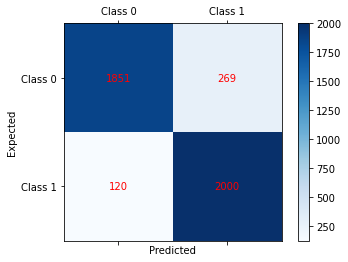

In [42]:
# Δημιουργήστε ένα confusion matrix για οπτικοποίηση της απόδοσης του μοντέλου
# Import του confusion matrix function
from sklearn.metrics import confusion_matrix
# Υπολογισμός 
conf_mat = confusion_matrix(y_true=true_labels, y_pred=predicted_labels)
# Ορισμός των labels 
labels = ['Class 0', 'Class 1']
# Ξεκινήστε ένα άδειο σχήμα
fig = plt.figure()
# Προσθέστε άξονα στο σχήμα
ax = fig.add_subplot(111)
# Προσθέστε τον πίνακα
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
# Εμφάνιση γραμμής χρωμάτων
fig.colorbar(cax)
# Αφαίρεση των x και y ticks
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
# Προσθέστε τα labels x και y
plt.xlabel('Predicted')
plt.ylabel('Expected')
# Προσθέστε νέα x και y ticks
for i in range(2):
    for j in range(2):
        ax.text(j, i, conf_mat[i, j], ha='center', va='center', color='r')
# Τυπώστε τον πίνακα
plt.show()

Στον παραπάνω πίνακα, κάθε σειρά αντιστοιχεί σε μια κλάση και δείχνει πόσο συχνά το μοντέλο ταξινόμησε σωστά (π.χ. κλάση 0 ως κλάση 0) ή λάθος (π.χ. κλάση 0 ως κλάση 1). Περισσότερες λεπτομέρειες για περαιτέρω μετρικές: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#:~:text=sklearn.,precision_recall_fscore_support&text=The%20precision%20is%20intuitively%20the,the%20number%20of%20false%20negatives.

## Δέντρο απόφασης

Τώρα που έχουμε δει την απόδοση της λογιστικής παλινδρόμησης, μπορούμε να διερευνήσουμε μεθόδους ταξινόμησης βάσει δέντρων και να δούμε αν μπορούν να αποδώσουν ακόμη καλύτερα.

In [25]:
# Import 
from sklearn import tree

model_score = []

true_labels = []

predicted_labels = []

our_cv = RepeatedKFold(n_splits=10, n_repeats=10)
# Ξεκινάμε τον decision tree classifier χωρίς να του ορίσουμε το βάθος. 
dec_tree = tree.DecisionTreeClassifier()

for i_train, i_test in our_cv.split(X):

    X_train, X_test, y_train, y_test = X.iloc[i_train], X.iloc[i_test], y.iloc[i_train], y.iloc[i_test]

    dec_tree.fit(X_train, y_train.astype('int'))

    y_pred_test = dec_tree.predict(X_test)

    model_score.append(accuracy_score(y_test.astype('int'), y_pred_test.astype('int')))

    true_labels.extend(y_test.astype('int'))

    predicted_labels.extend(y_pred_test.astype('int'))

In [26]:
print("Η μέση ακρίβεια του δέντρου απόφασης είναι: "+str(np.mean(model_score))+" %")

Η μέση ακρίβεια του δέντρου απόφασης είναι: 0.9311018826135106 %


<ipython-input-27-320ae2ccdb8d>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-27-320ae2ccdb8d>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


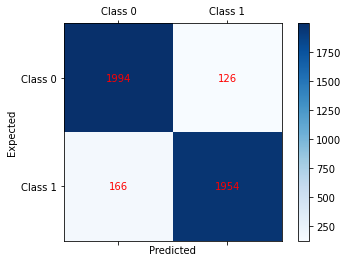

In [27]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true=true_labels, y_pred=predicted_labels)

labels = ['Class 0', 'Class 1']

fig = plt.figure()

ax = fig.add_subplot(111)

cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)

fig.colorbar(cax)

ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)

plt.xlabel('Predicted')
plt.ylabel('Expected')

for i in range(2):
    for j in range(2):
        ax.text(j, i, conf_mat[i, j], ha='center', va='center', color='r')

plt.show()

## Τυχαίο δάσος 

In [28]:
# Import του Random forest classifier
from sklearn.ensemble import RandomForestClassifier

model_score = []

true_labels = []

predicted_labels = []

our_cv = RepeatedKFold(n_splits=10, n_repeats=10)

dec_tree =RandomForestClassifier(n_estimators=100)

for i_train, i_test in our_cv.split(X):

    X_train, X_test, y_train, y_test = X.iloc[i_train], X.iloc[i_test], y.iloc[i_train], y.iloc[i_test]

    dec_tree.fit(X_train, y_train.astype('int'))

    y_pred_test = dec_tree.predict(X_test)

    model_score.append(accuracy_score(y_test.astype('int'), y_pred_test.astype('int')))

    true_labels.extend(y_test.astype('int'))

    predicted_labels.extend(y_pred_test.astype('int'))

In [29]:
print("Η μέση ακρίβεια του τυχαίου δάσους είναι: "+str(np.mean(model_score))+" %")

Η μέση ακρίβεια του τυχαίου δάσους είναι: 0.963233665559247 %


<ipython-input-30-6d7a2a7c1c0d>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-30-6d7a2a7c1c0d>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


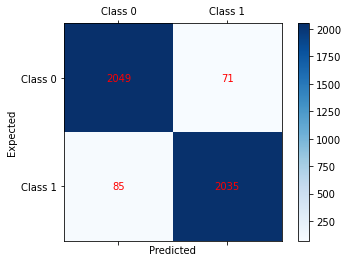

In [30]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true=true_labels, y_pred=predicted_labels)

labels = ['Class 0', 'Class 1']

fig = plt.figure()

ax = fig.add_subplot(111)

cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)

fig.colorbar(cax)

ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)

plt.xlabel('Predicted')
plt.ylabel('Expected')

for i in range(2):
    for j in range(2):
        ax.text(j, i, conf_mat[i, j], ha='center', va='center', color='r')

plt.show()

Φαίνεται λοιπόν, ότι οι μέθοδοι που βασίζονται σε δέντρα μπορούν να προβλέψουν αυτό το σύνολο δεδομένων καλύτερα από τη λογιστική παλινδρόμηση. Επίσης, από τις μεθόδους που βασίζονται σε δέντρα αποφάσεων, τα τυχαία δάση φαίνεται να είναι η βέλτιστη μέθοδος. Μπορούμε να υποθέσουμε ότι δεδομένου του ότι οι μέθοδοι του δέντρου αποφάσεων είναι σε θέση να συλλάβουν σχέσεις που δεν είναι γραμμικές και δεδομένου ότι αποδίδουν καλύτερα, τότε αυτό το σύνολο δεδομένων έχει πράγματι μη γραμμικές σχέσεις μεταξύ προβλέψεων και τάξεων.

# Συγχαρητήρια μάθατε να κάνετε ταξινόμηση!

## Άσκηση 10

Θα επαναλάβουμε αυτά που μόλις μάθαμε σε ένα διαφορετικό παράδειγμα.
Η μηχανική μάθηση είναι πολύ ευέλικτη και μπορείτε να εφαρμόσετε τον ίδιο κώδικα σε σχεδόν οποιοδήποτε πλαίσιο. 
Εδώ έχουμε ένα σύνολο δεδομένων για να ελέγξουμε αν ένα χαρτονόμισμα δολαρίου είναι αυθεντικό ή πλαστό.

Tο Banknote Dataset περιλαμβάνει την πρόβλεψη εάν ένα χαρτονόμισμα είναι αυθεντικό δεδομένου ενός αριθμού χαρακτηριστικών που λαμβάνονται από μια φωτογραφία.

Πρόκειται για ένα δυαδικό πρόβλημα ταξινόμησης (2 τάξεων). Ο αριθμός των παρατηρήσεων για κάθε τάξη δεν είναι ισορροπημένος. Υπάρχουν 1.372 παρατηρήσεις με 4 μεταβλητές εισόδου και 1 μεταβλητή στόχο. Τα ονόματα των μεταβλητών έχουν ως εξής:

- Variance of Wavelet Transformed image (συνεχής).
- Skewness of Wavelet Transformed image (συνεχής).
- Kurtosis of Wavelet Transformed image (συνεχής).
- Entropy of image (συνεχής).
- Class (0 for authentic, 1 for inauthentic).


Χρησιμοποιήστε τις τρεις τεχνικές ταξινόμησης που μάθαμε και προσπαθήστε να προβλέψετε ποια χαρτονομίσματα είναι πρωτότυπα και ποια ψεύτικα. 
(Συμβουλή: Θυμηθείτε την εξισορρόπηση δεδομένων)

Πηγή:

http://archive.ics.uci.edu/ml/datasets/banknote+authentication

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.